**SIN-393 - Introdução à Visão Computacional (2022-2)**

# Aula 07 - Classificadores: K-NN, Bayes e SVM

Prof. João Fernando Mari ([*joaofmari.github.io*](https://joaofmari.github.io/))

---

## Importando as bibliotecas necessárias
---

In [1]:
import numpy as np

from scipy import spatial, stats
from sklearn import datasets, model_selection, preprocessing, neighbors, metrics, svm, naive_bayes

import matplotlib.pylab as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
import pandas as pd

%matplotlib notebook

## Preparando o conjunto de dados Iris
---
* Vamos utilizar um conjunto de dados muito conhecido, o Iris dataset.
* 3 Classes:
    * Iris Setosa;
    * Iris Versicolor;
    * Iris Virginica.
* 150 objetos:   
    * 50 objetos de cada classe.
* 4 Características:
    * Comprimento da sépala;
    * Largura da sépala;
    * Comprimento da pétala;
    * Largura da pétala.
    
<img src='figuras/iris_dataset_ok.png' style="height:300px"><img>
*https://en.wikipedia.org/wiki/Iris_flower_data_set*

    
* Referências:
    * https://en.wikipedia.org/wiki/Iris_flower_data_set
    * R. A. Fisher (1936). "The use of multiple measurements in taxonomic problems" (PDF). Annals of Eugenics 7 (2): 179–188.
    * http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html 

In [2]:
# Carrega o conjunto de dados Iris dataset
iris = datasets.load_iris()

# Dados
X = iris.data
# Rótulos
y = iris.target

In [3]:
# Número de amostras
num_objs = X.shape[0]
# Número de caracteristicas
num_feat = X.shape[1]
# Número de classes
num_classes = len(np.unique(y))
# Nomes das caracteristicas
feat_names = iris.feature_names
# Nomes das classes
class_names = list(iris.target_names)

In [4]:
print(f'Número de amostras: {num_objs}') 
print(f'Número de caracteristicas: {num_feat}')
print(f'Características: {str(feat_names)[1:-1]}')
print(f'Número de classes: {num_classes}')
print(f'Classes: {str(class_names)[1:-1]}')

Número de amostras: 150
Número de caracteristicas: 4
Características: 'sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'
Número de classes: 3
Classes: 'setosa', 'versicolor', 'virginica'


### Visualizando o Iris dataset

In [5]:
df = pd.DataFrame(X, columns=feat_names)
df['class'] = y

pd.set_option('display.expand_frame_repr', False)
### print(df)
display(df)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  class
0                  5.1               3.5                1.4               0.2      0
1                  4.9               3.0                1.4               0.2      0
2                  4.7               3.2                1.3               0.2      0
3                  4.6               3.1                1.5               0.2      0
4                  5.0               3.6                1.4               0.2      0
..                 ...               ...                ...               ...    ...
145                6.7               3.0                5.2               2.3      2
146                6.3               2.5                5.0               1.9      2
147                6.5               3.0                5.2               2.0      2
148                6.2               3.4                5.4               2.3      2
149                5.9               3.0                5.1      

<IPython.core.display.Javascript object>


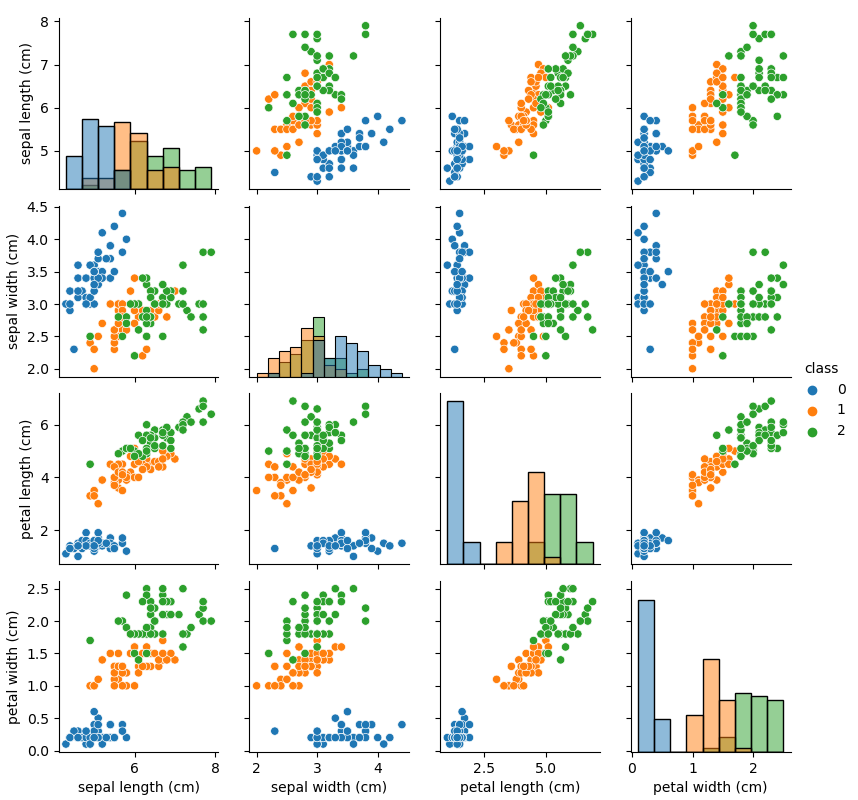

In [6]:
g = sns.PairGrid(df, hue='class', vars=feat_names, palette='tab10')
g.fig.set_size_inches(8, 8)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

## K-vizinhos mais próximos
----
### Vizinhos mais próximos (*Nearest neighbors*):
* Uma das abordagens de classificação mais simples.
* Técnica supervisionada não paramétrica.
* Dado um conjunto de dados $X$ com $N$ amostras já classificadas em $M$ classes $C_i$, queremos classificar um novo objeto $x$.
* Para isso basta identificar a amostra em $X$ mais próxima (semelhante) a $x$ e atribuir $x$ a esta classe.
* A semelhança é medida por meio de alguma métrica no espaço de características.
    * Geralmente, distância Euclidiana.
        
        
### K-vizinhos mais próximos (*K-nearest neighbors*):
* Extensão do método dos vizinhos mais próximos.
* Calcula-se os $k$ ($k$ é um número inteiro positivo) vizinhos mais próximos do novo individuo.
* A classe é definida como a mais frequente entre os $k$-vizinhos.
* Em caso de empate, a classe é escolhida arbitrariamente.

### Implementando do princípio (*from scratch*)

In [7]:
class KnnSimples:
    """ Implemetação simples de um classificador K-NN.
    
    Reference
    ---------
    [1] COSTA & CESAR-JR. Shape analisys and classification: theory and practice. CRC Press, 2000. 
        Seção 8.2: Supervised Pattern Classification.
    """
    
    def __init__(self, k=1):
        """ Construtor """
        self.k = k

    def fit(self, X_treino, y_treino):
        """ Treinamento do modelo  """
        print('\nTreinando o modelo...')
        
        self.X_treino = X_treino
        self.y_treino = y_treino
        
    def predict(self, X_teste, verbose=False):
        """ Classifica um conjunto de objetos ainda não apresentados """
        print('\nTestando o modelo...')

        # Objetos do conjunto de testes
        self.X_teste = X_teste
        
        # Matriz de distâncias entre os objetos do conjunto de testes do conjunto de treino
        #     Linhas: conjunto de testes. Colunas: Conjunto de treino
        self.dist_mat = spatial.distance.cdist(self.X_teste, self.X_treino, 'euclidean')
        if verbose:
            print('\nMatriz de distâncias: ')
            print(self.dist_mat.shape)
            with np.printoptions(precision=4, suppress=True):
                print(self.dist_mat)

        # Indices dos objetos do conjunto de treino mais próximos de cada objeto do conjunto de testes.
        # ---> Apenas se k = 1 (vizinhos mais próximos)
        ### min_dist_i = self.dist_mat.argmin(axis=1)
        
        # ---> Se k >= 1
        min_dist_i = self.dist_mat.argsort(axis=1)[:,:self.k]
        
        if verbose:
            print('\nÍndices dos vizinhos mais próximos: ')
            print(min_dist_i.shape)
            print(min_dist_i)

        # Obtém a classe dos objetos no conjunto de treino mais próximos de cada objeto do conjunto de testes.
        y_pred = self.y_treino[min_dist_i]
        
        # Classifica as amostras como a classe mais frequente
        y_pred = np.array([np.bincount(y_pred_).argmax() for y_pred_ in y_pred])
        
        if verbose:
            print('\nClasses dos vizinhos mais próximos: ')
            print(y_pred.shape)
            print(y_pred)

        return y_pred

### Preparando o conjunto de dados

In [8]:
# Vamos manter as três classes do conjunto Iris: Setosa (0) Versicolor (1) e Virginica (2).
X = iris.data
y = iris.target

# Vamos selecionar apenas 2 caracteristicas:
# Comprimento da sepala (0) e Largura da Sépala
X_ = X[:, :2]

In [9]:
# Dividindo o conjunto de dados (70% treino e 30% teste).
X_treino, X_teste, y_treino, y_teste = model_selection.train_test_split(X_, y, 
                                                                        test_size=0.3, 
                                                                        random_state=42)

### Normalizando as caracteristicas

In [10]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_treino)

X_treino_norm = scaler.transform(X_treino)
X_teste_norm = scaler.transform(X_teste)

### Treinando o modelo com $k=1$

In [11]:
knn = KnnSimples()

knn.fit(X_treino_norm, y_treino)


Treinando o modelo...


In [12]:
pred_knn = knn.predict(X_teste_norm)


Testando o modelo...


#### A matriz de distâncias gerada pelo K-nn

In [13]:
print(knn.dist_mat)
print(knn.dist_mat.shape)

[[1.20164277 0.24115957 0.80538815 ... 2.90096031 0.60082139 1.29772084]
 [3.36668621 2.5053335  1.87923901 ... 0.49464175 2.88084273 2.55574541]
 [2.69578213 1.7549558  1.97369994 ... 4.06511646 2.29101588 1.20164277]
 ...
 [2.2164815  0.86627158 0.36173935 ... 2.41616444 1.61741054 0.53866919]
 [3.59991767 2.85292138 2.26628421 ... 0.53866919 3.15526001 2.97692178]
 [3.12050853 2.41616444 1.87753222 ... 0.86627158 2.68218082 2.64971988]]
(45, 105)


<IPython.core.display.Javascript object>


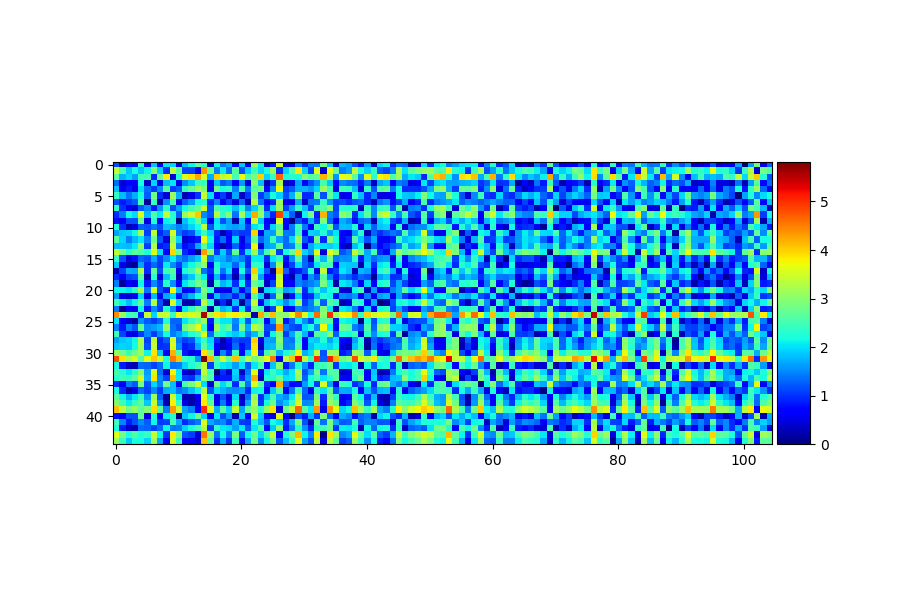

In [14]:
plt.figure(figsize=(9, 6))
ax = plt.gca()
im = ax.imshow(knn.dist_mat, cmap='jet')
# Plot colorbar
#   https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

#### Testando o modelo treinado

In [15]:
acertos = y_teste == pred_knn

print('Real:')
print(y_teste)
print('Predição:')
print(pred_knn)
print('Acerto/Erro:')
print(acertos.astype(int))

Real:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0]
Predição:
[1 0 2 1 1 0 1 2 1 2 2 0 0 0 0 2 2 1 1 1 0 1 0 1 2 1 1 2 0 0 0 0 2 0 0 1 2
 0 0 0 2 2 2 0 0]
Acerto/Erro:
[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 0 0
 1 1 1 1 0 0 1 1]


In [16]:
print('\nMatriz de confusão:')
print(metrics.confusion_matrix(y_teste, pred_knn))

print('\nRelatório de classificação:')
print(metrics.classification_report(y_teste, pred_knn))


Matriz de confusão:
[[19  0  0]
 [ 0  7  6]
 [ 0  6  7]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.54      0.54      0.54        13
           2       0.54      0.54      0.54        13

    accuracy                           0.73        45
   macro avg       0.69      0.69      0.69        45
weighted avg       0.73      0.73      0.73        45



#### Visualizando a classificação
* Função usada para visualizar o resultado de uma classificação
    * Circulos: amostras de treinamento
    * Triângulos: amostras de teste
        * Acertos: verde
        * Erros: vermelho

In [17]:
def vis_pred(clf_, X_treino_, y_treino_, X_teste_=None, y_teste_=None, title_str=''):
    """ Plota as fronteiras de decisão para um dado modelo.
    - 2 caracteristicas.
    - Até 3 classes.
    -----
    Legenda
    -------
    - Circulos: amostras de treinamento
    - Triângulos: amostras de teste
      - Verde: acertos
      - Vermelho: erros
    """
#     map_a = ListedColormap(['r', 'g', 'b'])
#     map_b = ListedColormap(['lightcoral', 'lightgreen', 'skyblue'])
    map_a = 'Set2'
    map_b = 'Pastel2'
    map_c = ListedColormap(['r', 'g'])

    h = .02  # step size in the mesh

    # Plot the decision boundary. 
    # - For that, we will assign a color to each point in the mesh [x_min, x_max] x [y_min, y_max].
    x_min, x_max = X_treino_[:, 0].min() - 1, X_treino_[:, 0].max() + 1
    y_min, y_max = X_treino_[:, 1].min() - 1, X_treino_[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = clf_.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(9, 9))
    
    # plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    plt.pcolormesh(xx, yy, Z, cmap=map_b, shading='auto')

    # Plot the training points
    plt.scatter(X_treino_[:, 0], X_treino_[:, 1], c=y_treino_, cmap=map_a, edgecolor='k', s=80, label='Training')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot the testing points
    if X_teste_ is not None:
        ### plt.scatter(X_teste_[:, 0], X_teste_[:, 1], c=y_teste_, cmap=map_a, edgecolor='k', marker='^', s=80, label='Testing')
        plt.scatter(X_teste_[:, 0], X_teste_[:, 1], c=y_teste_, cmap=map_c, edgecolor='k', marker='^', s=80, label='Testing')
    
    plt.gca().set_aspect('equal')
    plt.legend()
    
    # Set title
    plt.title(title_str)


Testando o modelo...


<IPython.core.display.Javascript object>


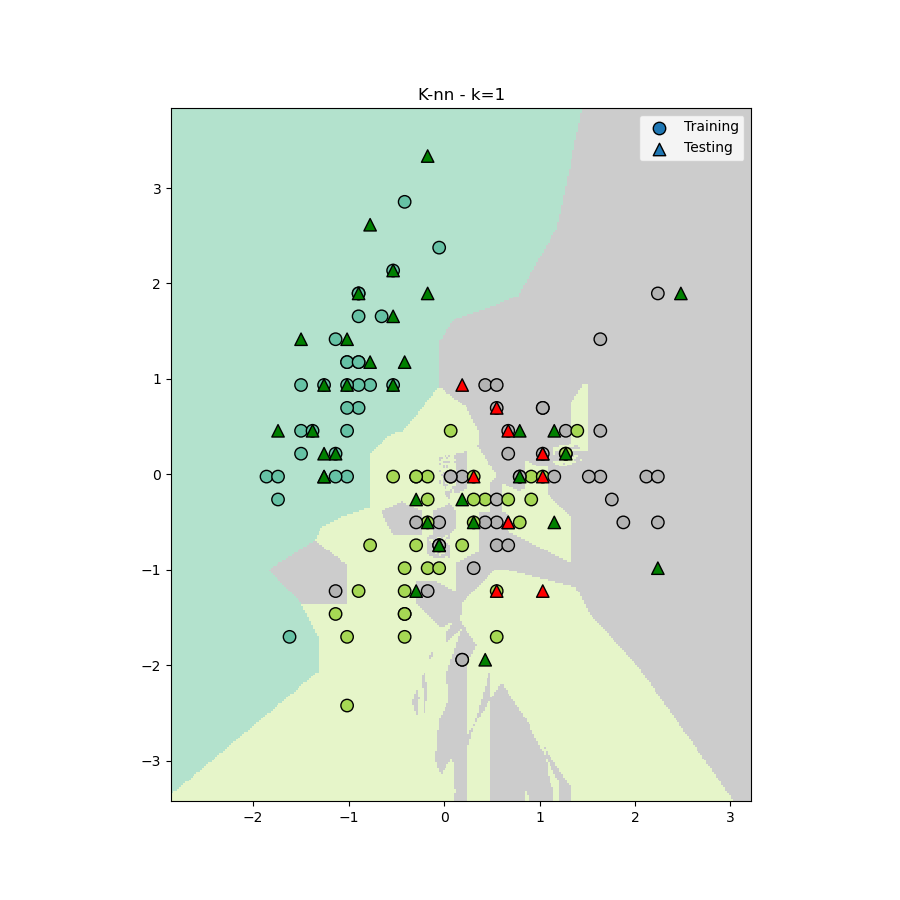

In [18]:
### vis_pred(knn, X_treino_norm, y_treino, X_teste_norm, y_teste, 'K-NN - k=1')
vis_pred(knn, X_treino_norm, y_treino, X_teste_norm, acertos.astype(int), 'K-nn - k=1')

### Treinando o modelo com $k=3$

In [19]:
knn = KnnSimples(k=3)

knn.fit(X_treino_norm, y_treino)


Treinando o modelo...


In [20]:
pred_knn = knn.predict(X_teste_norm)


Testando o modelo...


In [21]:
acertos = y_teste == pred_knn

print('Real:')
print(y_teste)
print('Predição:')
print(pred_knn)
print('Acerto/Erro:')
print(acertos.astype(int))

Real:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0]
Predição:
[1 0 2 1 1 0 1 2 1 2 2 0 0 0 0 2 2 1 2 2 0 1 0 2 2 1 2 2 0 0 0 0 2 0 0 2 2
 0 0 0 2 2 2 0 0]
Acerto/Erro:
[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0
 1 1 1 1 0 0 1 1]


In [22]:
print('\nMatriz de confusão:')
print(metrics.confusion_matrix(y_teste, pred_knn))

print('\nRelatório de classificação:')
print(metrics.classification_report(y_teste, pred_knn))


Matriz de confusão:
[[19  0  0]
 [ 0  6  7]
 [ 0  2 11]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.75      0.46      0.57        13
           2       0.61      0.85      0.71        13

    accuracy                           0.80        45
   macro avg       0.79      0.77      0.76        45
weighted avg       0.82      0.80      0.79        45




Testando o modelo...


<IPython.core.display.Javascript object>


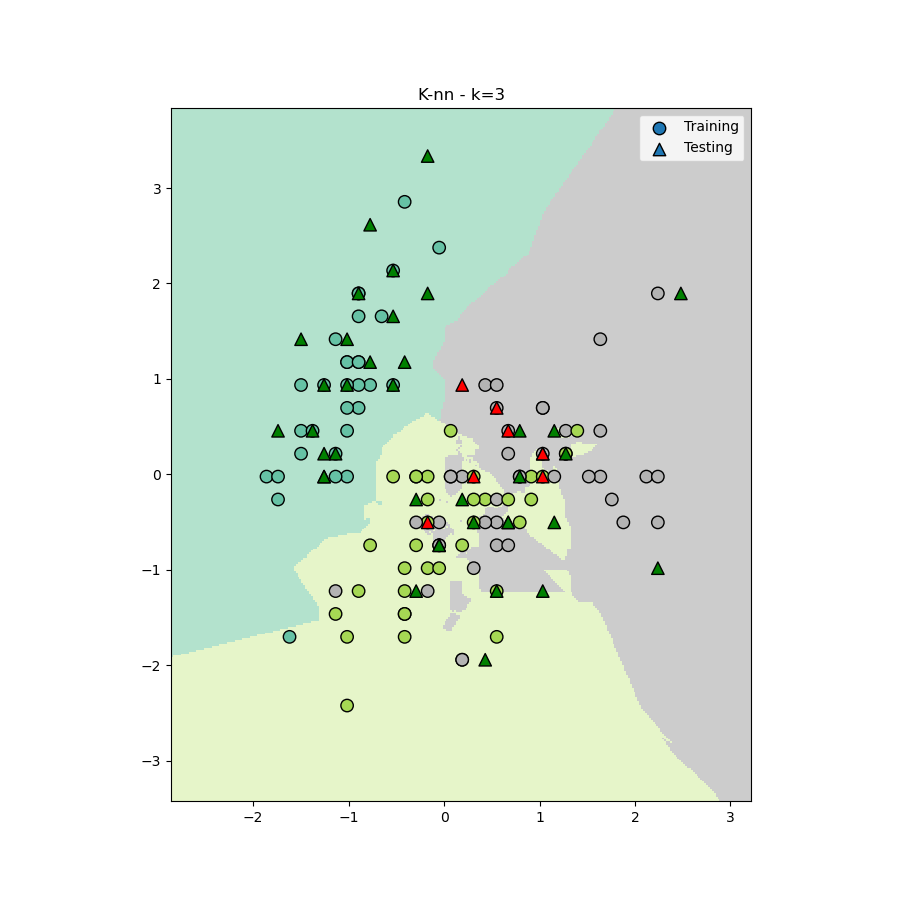

In [23]:
### vis_pred(knn, X_treino_norm, y_treino, X_teste_norm, y_teste)
vis_pred(knn, X_treino_norm, y_treino, X_teste_norm, acertos.astype(int), 'K-nn - k=3')

### Implementando com scikit-learn

In [24]:
clf = neighbors.KNeighborsClassifier(n_neighbors=3)

clf.fit(X_treino_norm, y_treino)
pred = clf.predict(X_teste_norm)

#### Testando a classificação

In [25]:
acertos = y_teste == pred

print('\nPredição:')
print(pred)
print('\nReal:')
print(y_teste)
print('\nAcerto/Erro:')
print(acertos.astype(int))


Predição:
[1 0 2 1 1 0 1 2 1 2 2 0 0 0 0 2 2 1 2 2 0 1 0 2 2 1 2 2 0 0 0 0 1 0 0 2 2
 0 0 0 2 2 1 0 0]

Real:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0]

Acerto/Erro:
[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 0 1 1 1]


In [26]:
print('\nMatriz de confusão:')
print(metrics.confusion_matrix(y_teste, pred))

print('\nRelatório de classificação:')
print(metrics.classification_report(y_teste, pred))


Matriz de confusão:
[[19  0  0]
 [ 0  8  5]
 [ 0  2 11]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.80      0.62      0.70        13
           2       0.69      0.85      0.76        13

    accuracy                           0.84        45
   macro avg       0.83      0.82      0.82        45
weighted avg       0.85      0.84      0.84        45




Testando o modelo...


<IPython.core.display.Javascript object>


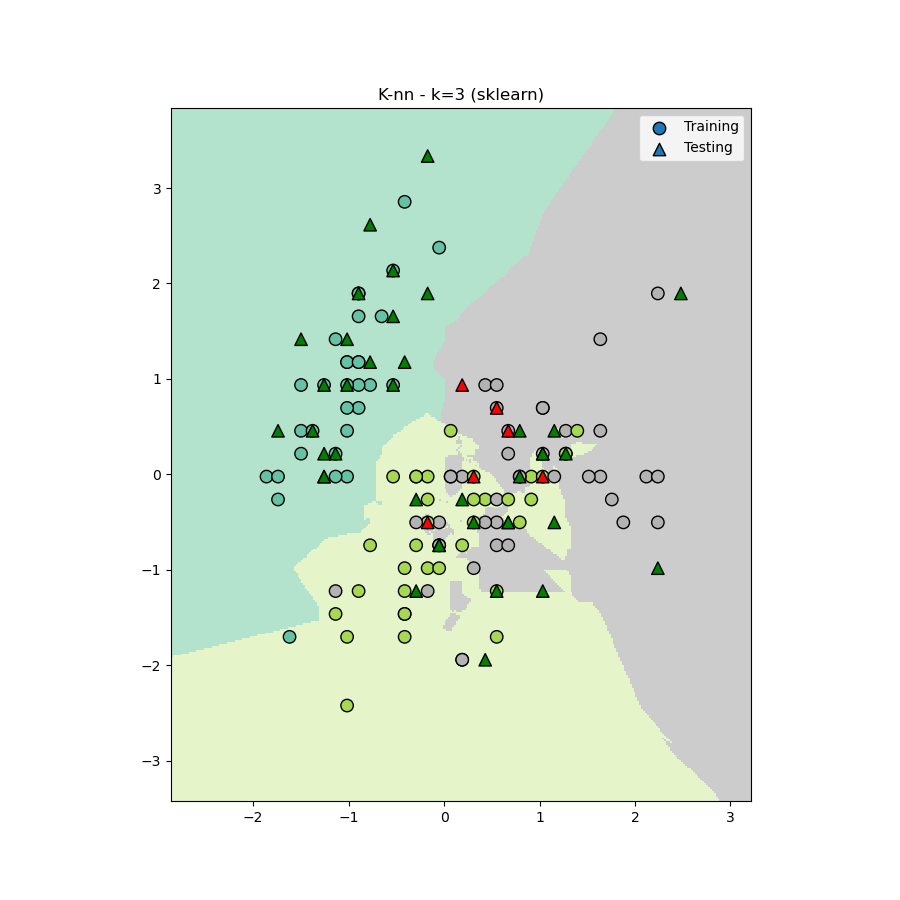

In [27]:
### vis_pred(knn, X_treino_norm, y_treino, X_teste_norm, y_teste)
vis_pred(knn, X_treino_norm, y_treino, X_teste_norm, acertos.astype(int), 'K-nn - k=3 (sklearn)')

## Classificador de Bayes 
---

### Teorema de classificação de Bayes I

* $P(C_0)$ e $P(C_1)$ são as probabilidades de um objeto (indivíduo) pertencer à classe $C_0$ ou à classe $C_1$, respectivamente.

$$
P(C_0) = \frac{\text{Núm. de objetos na classe } C_0}{\text{População total}}
$$

$$
P(C_1) = \frac{\text{Núm. de objetos na classe } C_1}{\text{População total}}
$$

* Caso a população total não seja conhecida, é possível realizar uma estimativa amostrando aleatoriamente N indivíduos da amostra.
    * Quanto maior o valor de $N$ melhor será a estimativa.

$$
P(C_0) = \frac{\text{Número de objetos da classe } C_0 \text{ na amostra}}{N\text{ (Tamanho da amostra)}}
$$

$$
P(C_1) = \frac{\text{Número de objetos da classe } C_1 \text{ na amostra}}{N\text{ (Tamanho da amostra)}}
$$

* Considerando apenas as probabilidades $P(C_0)$ e $P(C_1)$, o critério para decidir se um indivíduo observado pertence à classe $C_0$ ou $C_1$ consiste em selecionar a classe com a maior probabilidade.
    * Uma estratégia extremamente simplificada.
    
$$
\text{Se } P(C_0) >= P(C_1) \text{ então } C_0
$$

$$
\text{Se } P(C_0) < P(C_1) \text{ então } C_1
$$

### Teorema de classificação de Bayes II

* Melhores escolhas podem ser obtidas considerando informações adicionais sobre os indivíduos amostrados.
    * Ex.: Considerando a classificação de pessoas de acordo com o gênero (masculino/feminino) podemos considerar a medida da altura.
        * Definindo uma nova variável aleatória, $h$.
        
* Vamos estender o critério anterior em termos de probabilidade condicional $P(C_0|h)$.
    * $P(C_0|h)$: probabilidade de um indivíduo pertencer a classe $C_0$, após observar a característica $h$.
    * $P(C_1|h)$: probabilidade de um indivíduo pertencer a classe $C_1$, após observar a característica $h$.

$$
\text{Se } P(C_0|h) > P(C_1|h) \text{ decida por } C_0
$$

$$
\text{Se } P(C_1|h) > P(C_0|h) \text{ decida por } C_1
$$

* Na prática, é necessário conhecer as probabilidades condicionais, o que nem sempre é possível.

* Vamos redefinir o critério de probabilidade condicional, $P(C_0|h)$ e $P(C_1|h)$, em termos de funções de densidade $f(h|C_0)$ e $f(h|C_1)$.
    * $f(h|C_0)$ e $f(h|C_1)$: funções de densidade condicional de $h$ dado que um individuo pertence à classe $C_0$ ou $C_1$, respetivamente.
* Funções de densidade condicional $f(h|C_0)$ e $f(h|C_1)$ podem ser estimadas, caso não estejam disponíveis.


* Critério de classificação em termos de funções $f(h|C_1)$ e $f(h|C_2)$ considerando o teorema de Bayes:

$$
P(C_i|h) = \frac{f(h|C_i)P(C_i)}{\sum_{k=1}^{2}f(h|C_k)P(C_k)}
$$

* O critério de classificação pode ser reescrito como:

$$
P(C_1|h)\underset{C_2}{\overset{C_1}\gtreqless} P(C_2|h)
$$

* ou

$$
\frac{f(h|C_0)P(C_0)}{\sum_{k=1}^{2}f(h|C_k)P(C_k)} \underset{C_2}{\overset{C_1}\gtreqless} \frac{f(h|C_1)P(C_1)}{\sum_{k=1}^{2}f(h|C_k)P(C_k)} 
$$

* Este novo critério de decisão, denominado **regra de decisão de Bayes**, é obtido eliminando os denominadores:

$$
f(h|C_0)P(C_0) \underset{C_2}{\overset{C_1}\gtreqless} f(h|C_1)P(C_1)
$$

* Utilizando a razão de verossimilhança $L(h)$ e um limiar $T$:
    
$$
L(h) = \frac{f(h|C_1)}{f(h|C_0)}
$$

$$
T = \frac{P(C_0)}{P(C_1)}
$$

* Podemos reescrever os critérios anteriormente definidos como:

$$
T \underset{C_0}{\overset{C_1}\gtreqless} L(h)
$$

* Que pode ser lido como:

$$
\begin{cases}
\text{se } T >= L(h) \text{ então } C_0 \\\\
\text{senão } C_1
\end{cases}
$$

### Implementando do princípio (*from scratch*)

* Implementação simples, para fins didáticos, do algoritmo de classificação de Bayes.
    * Considera apenas problemas com duas classes, $C_0$ e $C_1$, e uma única variável observada (característica), $h$.
* Implementação baseada em [1].
* Cada classe é modelada por uma distribuição Gaussiana com a mesma média e o mesmo desvio padrão.
    * Função Gaussiana para 1 variável (caracteristica):
        <font size="4">
        $$
        G(h) = \frac{1}{\sqrt{2\pi\sigma^2}}e^-\frac{(h-\mu)^2}{2\sigma^2}
        $$
        </font> 

In [28]:
class BayesSimples:
    '''
    Implementacao simples de um classificador de Bayes para duas classes, C0 e C1. 
    considera apenas uma variavel observada, h.
    
    Reference
    ---------
    [1] COSTA & CESAR-JR. Shape analisys and classification: theory and practice. CRC Press, 2000. 
        Capitulo: 8.2. Supervised Pattern Classification
    '''
    
    def dist_normal(self, h, media, desv_p):
        """
        Calcula uma distribuição normal com média 'media' e desvio padrão 'desv_p'.
        """
        dist = (1. / np.sqrt(2*np.pi * desv_p**2)) * np.exp(-((h - media)**2.) / (2 * desv_p**2))

        return dist
    
    
    def fit(self, X_treino, y_treino, verbose=False):
        """
        Treina o modelo.
        """
        print('\nTreinando o modelo...')
        
        # Objetos das classes C0 e C1
        classe_0 = X_treino[y_treino==0]
        classe_1 = X_treino[y_treino==1]

        # Numero de objetos em cada classe
        num_objs_c0 = classe_0.shape[0]
        num_objs_c1 = classe_1.shape[0]
        # Numero total de objetos (N)
        num_objs = num_objs_c0 + num_objs_c1
        
        # P(C0) e P(C1):
        # - A probabilidade de um individuo pertencer a classe C0 ou C1:
        self.p_c0 = float(num_objs_c0) / num_objs
        self.p_c1 = float(num_objs_c1) / num_objs
        # PRINT
        if verbose:
            print('\nP(C0) = ', self.p_c0)
            print('P(C1) = ', self.p_c1)

        # Parametros das classes: média e desvio padrão
        self.param_c0 = [np.mean(classe_0, 0), np.std(classe_0, 0)]
        self.param_c1 = [np.mean(classe_1, 0), np.std(classe_1, 0)]
        # PRINT
        if verbose:
            print('\nMédia e desv. pad. (C0): ')
            print(self.param_c0)
            print('Média e desv. pad. (C1): ')
            print(self.param_c1)
        
        # h:
        # Caracteristica observada dos individuos
        self.h = np.linspace(np.min([classe_0.min(), classe_1.min()])-1., 
                             np.max([classe_0.max(), classe_1.max()])+1., 200)
        
        # f(h|C0) e f(h|C1) 
        # - Funçao densidade condicional de h, sabendo que o objeto pertence a classe C0 ou C1:
        self.fh_c0 = self.dist_normal(self.h, self.param_c0[0], self.param_c0[1])
        self.fh_c1 = self.dist_normal(self.h, self.param_c1[0], self.param_c1[1])

        # P(C0)f(h|C0) e P(C1)f(h|C1):
        # - Função densidade de probabilidade condicional ponderada de h.
        self.p_c0_fh_c0 = self.p_c0 * self.fh_c0
        self.p_c1_fh_c1 = self.p_c1 * self.fh_c1
        
        
    def predict(self, X_teste):
        """
        Classifica um conjunto de objetos ainda não apresentados.
        """
        print('\nTestando o modelo...')
        
        self.X_teste = X_teste

        # Bayes I
        # -------
        pred_i = np.zeros(self.X_teste.shape[0])
        
        if self.p_c0 > self.p_c1:
            pred_i[:] = 0
        else:
            pred_i[:] = 1
        
        # Bayes II
        # --------
        # Classificar os novos objetos. O valor da caracteristica h é conhecido.
        pred_ii = np.zeros(self.X_teste.shape[0])
        
        # p(C0)f(h|C0): A probabilidade de um objeto pertencer a C0 apos medir h
        p_c0_fh_c0_ = self.p_c0 * self.dist_normal(X_teste[:,0], self.param_c0[0], self.param_c0[1])
        # p(C1)f(h|C1): A probabilidade de um objeto pertencer a C1 apos medir h
        p_c1_fh_c1_ = self.p_c1 * self.dist_normal(X_teste[:,0], self.param_c1[0], self.param_c1[1])

        # SE p(C0)f(h|C0) > P(C1)f(h|C1) : Classe C0  
        pred_ii[p_c0_fh_c0_ >  p_c1_fh_c1_] = 0
        # SE P(C0)f(h|C0) <= P(C1)f(h|C1) : Classe C1
        pred_ii[p_c0_fh_c0_ <= p_c1_fh_c1_] = 1
        
        return pred_i, pred_ii
        
        
    def regiao_decisao(self):
        """ Funcao de verossimilhanca """
        L_h = self.fh_c1 / self.fh_c0
        # Limiar de decisao
        T = float(self.p_c0) / float(self.p_c1)

        # Valores de verossilhanca superiores a T : Classe C0
        h_c0 = self.h[L_h >= T]
        # Valores de verossilhanca inferiores a T : Classe C1
        h_c1 = self.h[L_h < T]
        
        # Regiao de decisao.
        self.regiao_decisao = (h_c0.min() + h_c1.max()) / 2.
        # DEBUG
        print(self.regiao_decisao)

        return T, self.regiao_decisao

    def plot(self, pred_i, pred_ii):
        """ Plota os modelos e as predições """
        # f(h|C0) e f(h|C1):
        # Funções densidade de probabilidade condicionais: 
        plt.figure(figsize=(9, 6))
        plt.xlim([self.h.min(), self.h.max()])
        plt.plot(self.h, self.fh_c0, color='blue', label='$f(h|C_0)$')
        plt.plot(self.h, self.fh_c1, color='red',  label='$f(h|C_1)$')
        plt.title('$f(h|C_0)$ e $f(h|C_1)$')
        plt.xlabel('h')
        plt.ylabel('$f(h|C_i)$')
        
        plt.legend()

        # P(C0)f(h|C0) e P(C1)f(h|C1):
        # Funcoes densidade de probabilidade condicionais ponderadas: 
        plt.figure(figsize=(9,6))
        plt.xlim([self.h.min(), self.h.max()])
        plt.plot(self.h, self.p_c0_fh_c0, color='blue', label='$P(C_0)f(h|C_0)$')
        plt.plot(self.h, self.p_c1_fh_c1, color='red',  label='$P(C_1)f(h|C_1)$')
        plt.title('$P(C_0)f(h|C_0)$ e $P(C_1)f(h|C_1)$')
        plt.xlabel('h')
        plt.ylabel('$P(C_i)f(h|C_i)$')   

        # Plota os objetos classificados
        [ plt.axvline(h_, c='blue', ls='dashed') for h_ in self.X_teste[pred_ii==0] ]
        [ plt.axvline(h_, c='red',  ls='dashed') for h_ in self.X_teste[pred_ii==1] ]
        
        plt.axvline(-1, c='blue', ls='dashed', label='Obj. class. como $C_0$.')
        plt.axvline(-1, c='red',  ls='dashed', label='Obj. class. como $C_1$.')
        plt.axvline(self.regiao_decisao, c='black', label='Limiar de decisão.')
        
        plt.legend()
        
        plt.show()

### Preparando o conjunto de dados

In [29]:
# Selecionamos apenas 2 classes:
# - Setosa (0) e Virginica (2).
X_ = iris.data[np.any([iris.target==0, iris.target==2], axis=0)]
y_ = iris.target[np.any([iris.target==0, iris.target==2], axis=0)]

# Ajusta os rótulos da classes. [0, 1]
y_[y_==2] = 1

# Selecionamos apenas 1 caracteristica:
# Comprimento da sepala (0) 
X_ = X_[:, 0]

# Mantém o conjunto de dados 2D
X_ = X_[:,np.newaxis]

In [30]:
# Divide o conjunto de dados (70% treino e 30% teste).
X_treino, X_teste, y_treino, y_teste = model_selection.train_test_split(X_, y_, 
                                                                        test_size=0.3, 
                                                                        random_state=42)

### Normalizando as caracteristicas

In [31]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_treino)

X_treino_norm = scaler.transform(X_treino)
X_teste_norm = scaler.transform(X_teste)

### Treinando o classificador

In [32]:
# Cria uma instância do classificador
clf = BayesSimples()

# Treinando o classificador
clf.fit(X_treino_norm, y_treino, verbose=True)


Treinando o modelo...

P(C0) =  0.4714285714285714
P(C1) =  0.5285714285714286

Média e desv. pad. (C0): 
[array([-0.88780462]), array([0.35449659])]
Média e desv. pad. (C1): 
[array([0.79182575]), array([0.67069755])]


### Testando o modelo treinado

In [33]:
# Predição. Testando o classificador
bayes_1, bayes_2 = clf.predict(X_teste_norm)

# Calculando o limiar de decisão.
T, hp = clf.regiao_decisao()


Testando o modelo...
-0.23135865804153788


In [34]:
print('\nClassificacao (Bayes I):')
print(bayes_1)

print('\nClassificacao (Bayes II):')
print(bayes_2)

print(f'\nLimiar de decisao: {T:.4f}')
print(f'\nHiperplano separação: {hp:.4f}')


Classificacao (Bayes I):
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]

Classificacao (Bayes II):
[1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0.
 1. 1. 0. 1. 0. 1.]

Limiar de decisao: 0.8919

Hiperplano separação: -0.2314


<IPython.core.display.Javascript object>


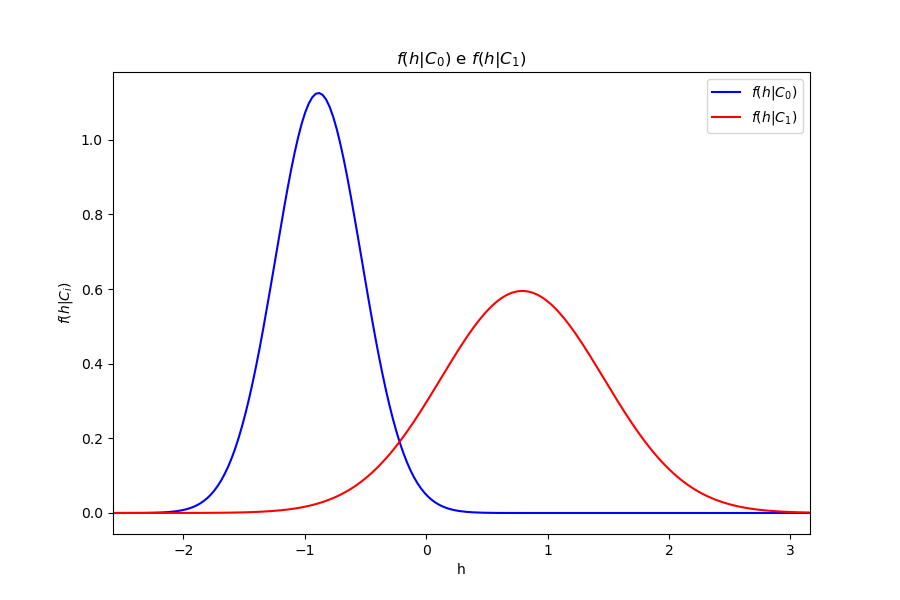

<IPython.core.display.Javascript object>


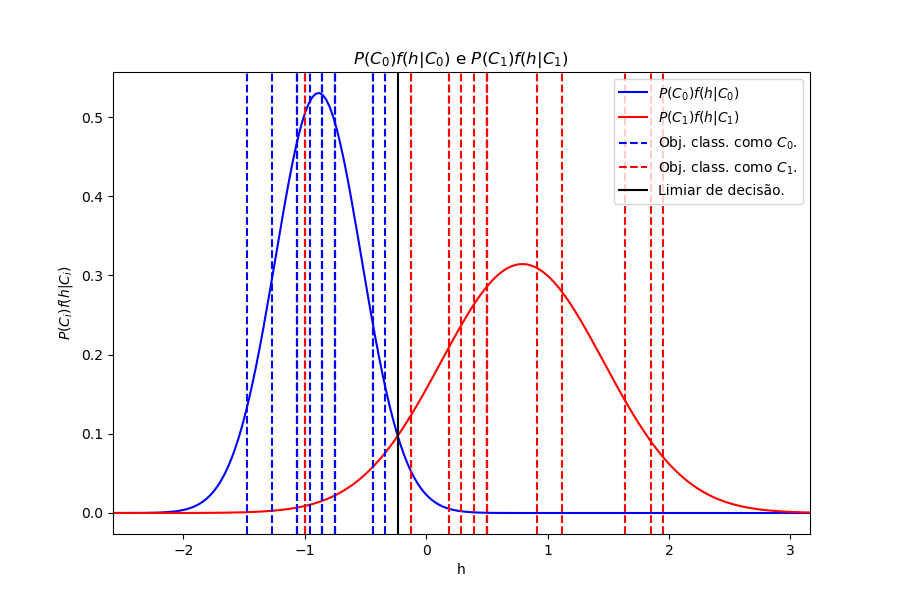

In [35]:
# Plotando o modelos das classes e o limiar de decisão.
clf.plot(bayes_1, bayes_2)

### Implementando como  o scikit-learn
---

#### Preparando o conjunto de dados

In [36]:
# Vamos manter as três classes do conjunto Iris: Setosa (0) Versicolor (1) e Virginica (2).
X = iris.data
y = iris.target

# Vamos selecionar apenas 2 caracteristicas:
# Comprimento da sepala (0) e Largura da Sépala
X_ = X[:, :2]

In [37]:
# Dividindo o conjunto de dados (70% treino e 30% teste).
X_treino, X_teste, y_treino, y_teste = model_selection.train_test_split(X_, y, 
                                                                        test_size=0.3, 
                                                                        random_state=42)

#### Normalizando as características

In [38]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_treino)

X_treino_norm = scaler.transform(X_treino)
X_teste_norm = scaler.transform(X_teste)

#### Treinando o classificador de Bayes (scikit-learn)

In [39]:
clf = naive_bayes.GaussianNB()

clf.fit(X_treino_norm, y_treino)


GaussianNB()

#### Testando o modelo treinado

In [40]:
pred = clf.predict(X_teste_norm)

In [41]:
acertos = y_teste == pred

print('\nPredição:')
print(pred)
print('\nReal:')
print(y_teste)
print('\nAcerto/Erro:')
print(acertos.astype(int))


Predição:
[1 0 2 1 2 0 1 2 1 1 2 0 0 0 0 2 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 2 0 0 1 2
 0 0 0 1 2 2 0 0]

Real:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0]

Acerto/Erro:
[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0
 1 1 1 0 0 0 1 1]


In [42]:
print('\nMatriz de confusão:')
print(metrics.confusion_matrix(y_teste, pred))

print('\nRelatório de classificação:')
print(metrics.classification_report(y_teste, pred))


Matriz de confusão:
[[19  0  0]
 [ 0  7  6]
 [ 0  2 11]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.78      0.54      0.64        13
           2       0.65      0.85      0.73        13

    accuracy                           0.82        45
   macro avg       0.81      0.79      0.79        45
weighted avg       0.83      0.82      0.82        45



## Suport Vector Machines (SVM)
---
* Constituem uma classe de funções de discriminação lineares. 

### Kernel trick
* As SVMs realizam um mapeamento dos objetos $\boldsymbol{x}_k$, representados pelos respectivos vetores de características, para uma dimensão elevada $\boldsymbol{y}_k = \varphi(\boldsymbol{x}_k)$. 
    * Em uma dimensão suficientemente elevada, dados pertencentes a duas classes distintas podem ser separadas por um hiperplano.
    * Esta técnica é conhecida como kernel trick (ou truque do kernel).
    * Kernels comuns utilizados pelas SVMs:
        * Linear
        * Polinomial
        * Gaussiano
        * RBF - Radial Basis Function    
        
<img src='figuras/svm_proj.png' style="height:300px">,<img>
*Statnikov et al. A Gentle Introduction to Support Vector Machines in Biomedicine, AMIA 2009.*

### Função discriminante linear
* Considerando a função de discriminação linear generalizada, $g(\boldsymbol{y})$, definida pela equação:

$$
g(\boldsymbol{y}) = \sum_{i=i}^{d}a_{i}\varphi (x_{i})
$$

- $a$ é o vetor de pesos. 
- $d$ é a dimensão do espaço de características após o kernel trick.
* $g(\boldsymbol{y})$ é a função discriminante define um hiperplano linear no espaço de características (aumentado) quando $g(\boldsymbol{x}) = 0$. 

Um objeto $\boldsymbol{y}_k$ é classificado em $C_0$ ou $C_1$ de acordo com a Equação:

$$
g(\boldsymbol{y}_{k}) \underset{C_1}{\overset{C_0}\gtreqless} 0
$$

### Margem máxima de separação
* As SVMs buscar traçar um hiperplano de separação o mais distânte possível dos objetos das classes separadas

<img src='figuras/svm_ok_2.png' style="height:300px"><img>
*Mari, J.F. Análise quantitativa de culturas de neurônios em matrizes de microeletrodos por meio do processamento de imagens de microscopia confocal de fluorescência. Tese (doutorado). UFSCar, 2015.*

### Preparando o conjunto de dados

In [43]:
# Vamos manter as três classes do conjunto Iris: Setosa (0) Versicolor (1) e Virginica (2).
X = iris.data
y = iris.target

# Vamos selecionar apenas 2 caracteristicas:
# Comprimento da sepala (0) e Largura da Sépala
X_ = X[:, :2]

In [44]:
# Dividindo o conjunto de dados (70% treino e 30% teste).
X_treino, X_teste, y_treino, y_teste = model_selection.train_test_split(X_, y, 
                                                                        test_size=0.3, 
                                                                        random_state=42)

### Normalizando as características

In [45]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_treino)

X_treino_norm = scaler.transform(X_treino)
X_teste_norm = scaler.transform(X_teste)

### Implementando com o scikit-learn

#### SVM com kernel linear

In [46]:
svm_lin = svm.SVC(kernel='linear')

svm_lin.fit(X_treino_norm, y_treino)

pred = svm_lin.predict(X_teste_norm)

In [47]:
acertos = y_teste == pred

print('\nPredição:')
print(pred)
print('\nReal:')
print(y_teste)
print('\nAcerto/Erro:')
print(acertos.astype(int))


Predição:
[1 0 2 1 2 0 1 2 1 1 2 0 0 0 0 2 2 1 1 1 0 1 0 1 2 2 1 2 0 0 0 0 2 0 0 1 2
 0 0 0 1 2 2 0 0]

Real:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0]

Acerto/Erro:
[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0
 1 1 1 0 0 0 1 1]


In [48]:
print('\nMatriz de confusão:')
print(metrics.confusion_matrix(y_teste, pred))

print('\nRelatório de classificação:')
print(metrics.classification_report(y_teste, pred))


Matriz de confusão:
[[19  0  0]
 [ 0  7  6]
 [ 0  6  7]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.54      0.54      0.54        13
           2       0.54      0.54      0.54        13

    accuracy                           0.73        45
   macro avg       0.69      0.69      0.69        45
weighted avg       0.73      0.73      0.73        45



### SVM com kernel polinomial

In [49]:
svm_poly = svm.SVC(kernel='poly')

svm_poly.fit(X_treino_norm, y_treino)

pred = svm_poly.predict(X_teste_norm)

In [50]:
acertos = y_teste == pred

print('\nPredição:')
print(pred)
print('\nReal:')
print(y_teste)
print('\nAcerto/Erro:')
print(acertos.astype(int))


Predição:
[1 0 2 1 1 0 1 2 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 2 1 1 2 0 0 0 0 2 0 0 1 1
 0 0 0 1 1 2 0 0]

Real:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0]

Acerto/Erro:
[1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1
 1 1 1 0 1 0 1 1]


In [51]:
print('\nMatriz de confusão:')
print(metrics.confusion_matrix(y_teste, pred))

print('\nRelatório de classificação:')
print(metrics.classification_report(y_teste, pred))


Matriz de confusão:
[[19  0  0]
 [ 0 11  2]
 [ 0  9  4]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.55      0.85      0.67        13
           2       0.67      0.31      0.42        13

    accuracy                           0.76        45
   macro avg       0.74      0.72      0.70        45
weighted avg       0.77      0.76      0.74        45



### SVM com kernel RBF (padrão)

In [52]:
svm_rbf = svm.SVC(kernel='rbf') # defulat: kernel='rbf'

svm_rbf.fit(X_treino_norm, y_treino)

pred = svm_rbf.predict(X_teste_norm)

In [53]:
acertos = y_teste == pred

print('\nPredição:')
print(pred)
print('\nReal:')
print(y_teste)
print('\nAcerto/Erro:')
print(acertos.astype(int))


Predição:
[1 0 2 1 2 0 1 2 1 1 2 0 0 0 0 2 2 1 1 1 0 1 0 1 2 2 1 2 0 0 0 0 2 0 0 1 2
 0 0 0 1 2 2 0 0]

Real:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0]

Acerto/Erro:
[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0
 1 1 1 0 0 0 1 1]


In [54]:
print('\nMatriz de confusão:')
print(metrics.confusion_matrix(y_teste, pred))

print('\nRelatório de classificação:')
print(metrics.classification_report(y_teste, pred))


Matriz de confusão:
[[19  0  0]
 [ 0  7  6]
 [ 0  6  7]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.54      0.54      0.54        13
           2       0.54      0.54      0.54        13

    accuracy                           0.73        45
   macro avg       0.69      0.69      0.69        45
weighted avg       0.73      0.73      0.73        45



## Bibliografia
---
1. COSTA & CESAR-JR. **Shape analisys and classification: theory and practice**. CRC Press, 2000. 
    * Seção 8.2. Supervised Pattern Classification.
1. Statnikov et al. **A Gentle Introduction to Support Vector Machines in Biomedicine**, AMIA 2009.
1. Mari, J.F. Análise quantitativa de culturas de neurônios em matrizes de microeletrodos por meio do processamento de imagens de microscopia confocal de fluorescência. Tese (doutorado). UFSCar, 2015.
1. scikit-learn. 
    * https://scikit-learn.org/stable/
1. scikit-learn. Nearest neighbors
    * https://scikit-learn.org/stable/modules/neighbors.html
1. scikit-learn. Support vector machines
    * https://scikit-learn.org/stable/modules/svm.html
1. scikit-learn. Naive Bayes
    * https://scikit-learn.org/stable/modules/naive_bayes.html